# 4. Advanced grouping models

> [!WARNING]
> This tutorial and the associated functions are still under construction, only use these functions for development puprose 


For this tutorial we will simulate data for two participants, one with noise and one without. We make the simulation deterministic by providing the exact times at which we want the events to occur for two trials.
Importantly we will use the same source names and parameters for both participants, but we will swap the first two sources between the two participants. This will allow us to test the grouping model's ability to handle different event configuration across conditions or participants.

In [1]:
import numpy as np
import os.path as op
import hmp
from hmp import simulations
import matplotlib.pyplot as plt

sfreq = 100
n_events = 3
# Data creation/reading
## Simulation parameters
n_trials = 2
# Times (in milliseconds) for participant A: 3 events per trial, 2 trials with the following time structure:
# On trial 1 the events will occur at 100ms, 300ms, and 400ms after the simulated trial onset
# On trial 2 all inter-event duration were doubled and thus occur at 200ms, 600ms, and 800ms after the simulated trial onset
times = np.array([[100, 200, 100, 100],
                    [200, 400, 200, 200]], dtype='float64')
# Thus, on average, the events appear at 150, 450 and 600ms after trial onset
avg_times = np.cumsum(times.mean(axis=0))[:-1]

# Define source names and parameters, the same for both participants
names_a = ['bankssts-rh', 'bankssts-lh', 'caudalanteriorcingulate-rh', 'bankssts-lh']
# same but the two first sources are swapped
names_b = ['bankssts-lh', 'bankssts-rh','caudalanteriorcingulate-rh', 'bankssts-lh']
sources_a, sources_b = [], []
for name_a_i, name_b_i in zip(names_a, names_b):
    sources_a.append([name_a_i, 10., 4e-8])
    sources_b.append([name_b_i, 10., 4e-8])

## Now we simulated two datasets with the exact same structure except one is noise, one isn't
# Participant A is noisy
files_a = simulations.simulate(sources_a, n_trials, 1, 'dataset_a_raw', overwrite=True,
    sfreq=sfreq, times=times, noise=True, seed=1, path=op.join('sample_data', 'simulated'))
# Participant B has no noise
files_b = simulations.simulate(sources_b, n_trials, 1, 'dataset_b_raw', overwrite=True,
    sfreq=sfreq, times=times, noise=False, seed=1, path=op.join('sample_data', 'simulated'))


Simulating /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/simulated/dataset_a_raw_raw.fif
/home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/simulated/dataset_a_raw_raw.fif simulated
Simulating /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/simulated/dataset_b_raw_raw.fif
/home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/simulated/dataset_b_raw_raw.fif simulated


Next we read the data as we do for simulations (Tutorial 1)

In [2]:
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':5}
raws, events = [], []
for files in [files_a, files_b]:
    raws.append(files[0])
    events.append(np.load(files[1]))
event_a, event_b = events[0], events[1]

# Data reading
epoch_data = hmp.io.read_mne_data(raws, event_id=event_id, resp_id=resp_id, sfreq=sfreq,
        events_provided=events, verbose=False, subj_name=['a','b'])
positions = simulations.positions()
epoch_data

Processing participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/simulated/dataset_a_raw_raw.fif's raw eeg
2 trials were retained for participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/simulated/dataset_a_raw_raw.fif
Processing participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/simulated/dataset_b_raw_raw.fif's raw eeg
2 trials were retained for participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/simulated/dataset_b_raw_raw.fif


<xarray.Dataset> Size: 191kB
Dimensions:      (participant: 2, epoch: 2, channel: 59, sample: 100)
Coordinates:
  * epoch        (epoch) int64 16B 0 1
  * channel      (channel) <U7 2kB 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * sample       (sample) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
    event_name   (epoch) object 16B 'stimulus' 'stimulus'
    rt           (epoch) float64 16B 0.5 1.0
  * participant  (participant) <U1 8B 'a' 'b'
Data variables:
    data         (participant, epoch, channel, sample) float64 189kB -1.096e-...
Attributes:
    sfreq:             100.0
    offset:            0
    lowpass:           40.0
    highpass:          0.10000000149011612
    lower_limit_rt:    0
    upper_limit_rt:    inf
    reject_threshold:  None
    n_trials:          4

Next we preprocess the data and split conditions (or participants in this case). We will use the `hmp.preprocessing.Standard` class to handle the data preprocessing. We will also create a template for the event properties that we expect in our data.


In [3]:
# Preprocess the data for both participants using the Preprocessing class
hmp_data = hmp.preprocessing.Standard(epoch_data, n_comp=3)

# Create event property template
event_properties = hmp.patterns.HalfSine.create_expected(sfreq=epoch_data.sfreq)

# Select data for each participant
hmp_data_a = hmp.utils.participant_selection(hmp_data.data, 'a')
hmp_data_b = hmp.utils.participant_selection(hmp_data.data, 'b')

# Create TrialData objects for all data and for each participant
trial_data = hmp.trialdata.TrialData.from_preprocessed(preprocessed=hmp_data, pattern=event_properties.template)
trial_data_a = hmp.trialdata.TrialData.from_preprocessed(preprocessed=hmp_data_a, pattern=event_properties.template)
trial_data_b = hmp.trialdata.TrialData.from_preprocessed(preprocessed=hmp_data_b, pattern=event_properties.template)

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:165: UserWarning: Data will be modified inplace, re-read the data or use copy=True if multiplecalls to this function
  warn(


Here we illustrate the ground truth  estimates for the events in the noisy data. We will use these to compare the estimates obtained from the different model.


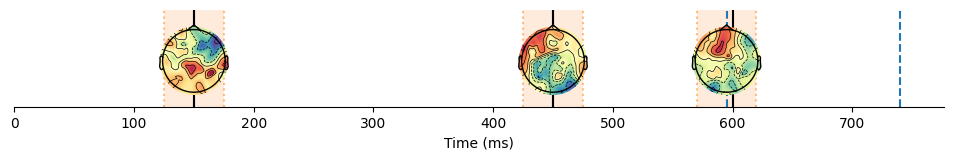

In [4]:
model = hmp.models.EventModel(event_properties, n_events=n_events)
# Recover generating parameters
sim_source_times, true_time_pars, true_channel_pars, _ = \
    simulations.simulated_times_and_parameters(event_a, model, trial_data_a)
# Fixing true parameter in model
model.time_pars = np.array([true_time_pars])
model.channel_pars = np.array([true_channel_pars])
# Ground truth
true_loglikelihood, true_estimates = model.transform(trial_data_a)
hmp.visu.plot_topo_timecourse(epoch_data, true_estimates, positions, as_time=True, colorbar=False)
plt.vlines(avg_times, 0, 1, 'k')

As can be seen the true model estimates the events at the correct time but the topographies are mainly dominated by noise because we only have two trials and the sources have a very low amplitude, thus the SNR is close to zero. Fitting the model on B however gives us the a perfect representation as it is noiseless. Based on this we can see that the last event of the noiseless B estimation is the cleaner version of the last event in A. With a bit of abstraction we can also see that the two first events between A and B are indeed reversed as we requested in the simulation.

Estimating 3 events model with 1 starting point(s)


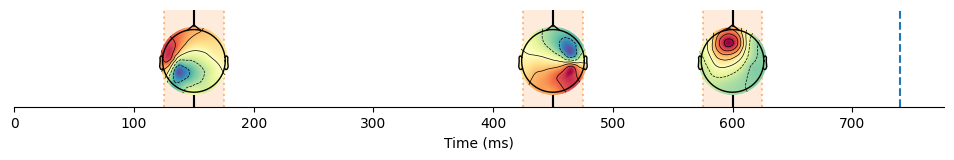

In [5]:
model = hmp.models.EventModel(event_properties, n_events=n_events)

# Fit and transform on noiseless B
lkh_b, estimates_b = model.fit_transform(trial_data_b)
hmp.visu.plot_topo_timecourse(epoch_data, estimates_b, positions, as_time=True, colorbar=False)
plt.vlines(avg_times, 0, 1, 'k')

If we first try to fit the model on A the estimates will be dominated by noise. This is because the model is not able to estimate the parameters correctly from the noisy data alone.

Estimating 3 events model with 1 starting point(s)


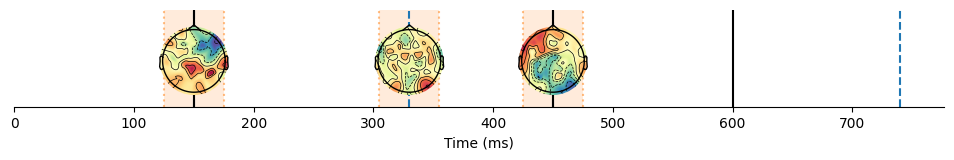

In [6]:
model = hmp.models.EventModel(event_properties, n_events=n_events)

# Fit and transform on noisy A
lkh_a, estimates_a = model.fit_transform(trial_data_a)
hmp.visu.plot_topo_timecourse(epoch_data, estimates_a, positions, as_time=True, colorbar=False)
plt.vlines(avg_times, 0, 1, 'k')

## Fit / transform

A first way to split conditions and use the information from one condition to estimate the other is to use the `fit/transform` architecture. In this example we can then fit the model to the data of B (noiseless) and transform the data of A using the parameters estimated on B:

Estimating 3 events model with 1 starting point(s)


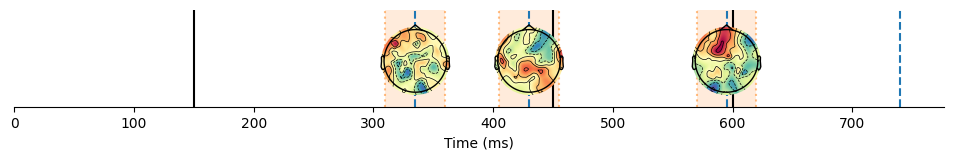

In [7]:
model = hmp.models.EventModel(event_properties, n_events=n_events)

# Fit on noiseless B
model.fit(trial_data_b)
# Transform on noisy A
lkh_a_transform, estimates_a_transform = model.transform(trial_data_a)
hmp.visu.plot_topo_timecourse(epoch_data, estimates_a_transform, positions, as_time=True, colorbar=False)
plt.vlines(avg_times, 0, 1, 'k')

In this case this turns out pretty bad because we estimate the two first events based on B while they are reversed in A. Thus the estimation of the `channel_pars` parameters does not help to correclty estimate the model in A, to the contrary doing so will actually make the estimates worse than if we had not used the parameters from B at all.

## Grouping models

HMP implements grouping models, models that share time and channel parameters across groups (e.g. condition or participant) based on a map. This map is a 2D array where each row corresponds to a level and each column corresponds to an expected event (Note we need to know how many events are present to write the map, thus this only works on the`EventModel` class). 

The values in the map indicate which sources are shared across participants. As a wrong example we could estimate a grouping where all the parameters for each event are shared across the two groups A and B.

In [8]:
# testing grouping model with all parameters shared across participants
channel_map = np.array([[0, 0, 0],    # All events share the same channel parameters
                        [0, 0, 0]])
time_map = np.array([[0, 0, 0, 0],    # All events share the same time parameters
                     [0, 0, 0, 0]])
grouping_dict = {'participant': ['a', 'b']}  # Define participant groups

# Fit the multilevel model with shared parameters and get estimates
lkh_comb, estimates_comb = model.fit_transform(
    trial_data,
    time_map=time_map,
    channel_map=channel_map,
    grouping_dict=grouping_dict
)

group "participant" analyzed, with groups: ['a', 'b']

Coded as follows: 
0: ['a']
1: ['b']

Channel map:
0:  [0 0 0]
1:  [0 0 0]

Time map:
0:  [0 0 0 0]
1:  [0 0 0 0]
Estimating 3 events model with 1 starting point(s)


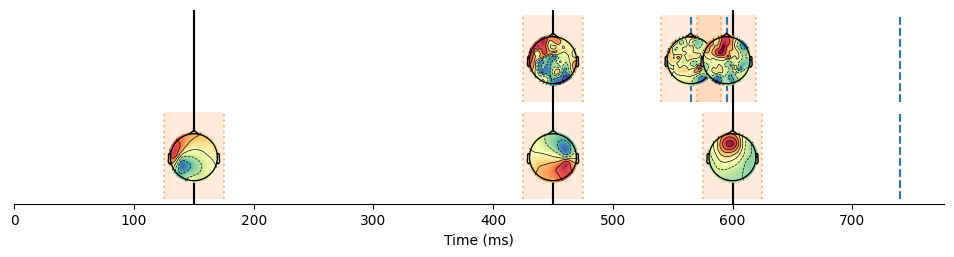

In [9]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates_comb, positions, as_time=True, colorbar=False, magnify=0.75, )
plt.vlines(avg_times,0,2, 'k')

In this case, we expect that the parameters are all shared, thus, the first event in A is moved to the second event of B as the first event in B is the second event in A.

Instead we can inform the model that we expect different topographies for the first two events

In [10]:
# testing grouping model with all parameters shared across participants
channel_map = np.array([[0, 0, 0],   # The two first events are not shared and will be estimated separatebly for both B and A
                        [1, 1, 0]])   
time_map = np.array([[0, 0, 0, 0],    # All events still share the same time parameters
                     [0, 0, 0, 0]])
grouping_dict = {'participant': ['a', 'b']}  # Define participant groups

# Fit the multilevel model with shared parameters and get estimates
lkh_comb, estimates_comb = model.fit_transform(
    trial_data,
    time_map=time_map,
    channel_map=channel_map,
    grouping_dict=grouping_dict
)

group "participant" analyzed, with groups: ['a', 'b']

Coded as follows: 
0: ['a']
1: ['b']

Channel map:
0:  [0 0 0]
1:  [1 1 0]

Time map:
0:  [0 0 0 0]
1:  [0 0 0 0]
Estimating 3 events model with 1 starting point(s)


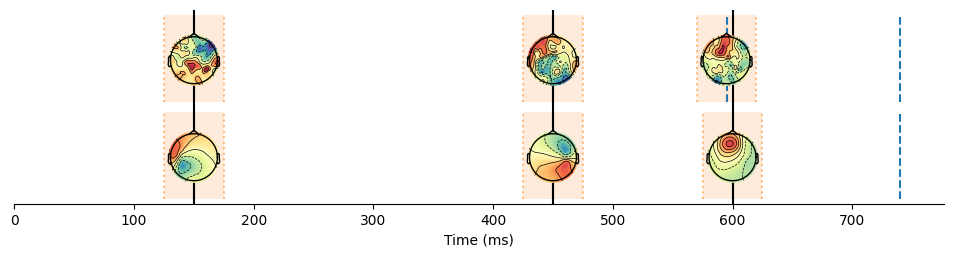

In [11]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates_comb, positions, as_time=True, colorbar=False, magnify=0.75, )
plt.vlines(avg_times,0,2, 'k')

In this case we do indeed recover the correct events, quite close to the ground truth. The first two events are estimated separately for A and B, while the third event is shared across both participants which does help the model to get the correct amplitude and time for the third event. 